In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import arma_generate_sample
from sklearn.metrics import mean_squared_error
from collections import deque
import os
from arch.univariate import ARX,GARCH,arch_model


In [2]:
def get_pricing(csv = '../data/INFY.csv'):
    df = pd.read_csv(csv, index_col = 'Date')
    df = df[df.index > '2010-01-01']
    cl = pd.DataFrame(df['Close'])
    cl['logClose'] = np.log(cl['Close'])
    cl['diffLogClose'] = cl['logClose'] - cl['logClose'].shift(1)
    cl['pctChange'] = cl['Close'].pct_change()
    cl = cl.dropna()
    return cl

In [3]:
def generate_arma(n=1000, ar_coeff=[0.6,], ma_coeff=[0.3,]):
    p = len(ar_coeff)
    q = len(ma_coeff)
    for i in range(q,n):
        x[i] += w[i]
        for j in range(q):
            x[i] += w[i-j-1]*ma_coeff[j]
    for i in range(p,n):
        for j in range(p):
            x[i] += x[i-j-1]*ar_coeff[j]
    return x

In [4]:
def generate_arma(n, ar_coeff=[0.6,], ma_coeff=[0.3,]):
    #this function appends 1 to ar and ma coeff. negates ar coeff
    #calls arma_generate_sample method.
    ar = np.r_[1, -np.array(ar_coeff)]
    ma = np.r_[1, np.array(ma_coeff)]
    print("generating ARMA(%d,%d)"%(len(ar_coeff), len(ma_coeff)))
    return arma_generate_sample(ar, ma, n)

In [5]:
# model = arma_generate_sample(ar=[1,0.5], ma=[1,-0.5], nsample=1000)
model1 = generate_arma(n=1000,ar_coeff=[0.5, -0.25], ma_coeff=[0.5, -0.3])

generating ARMA(2,2)


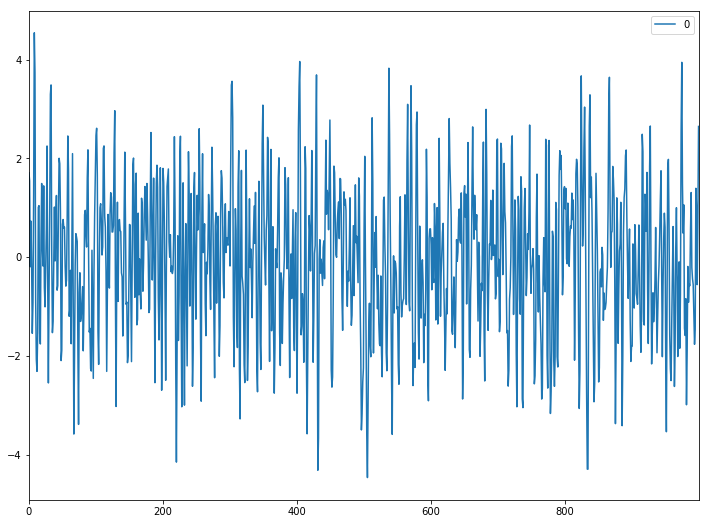

In [6]:
# pd.DataFrame(model).plot(figsize=(12,9))
pd.DataFrame(model1).plot(figsize=(12,9))

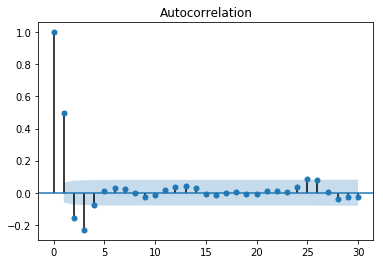

In [7]:
# plot_pacf(model, lags=30)
# plt.show()
plot_acf(model1, lags=30)
plt.show()


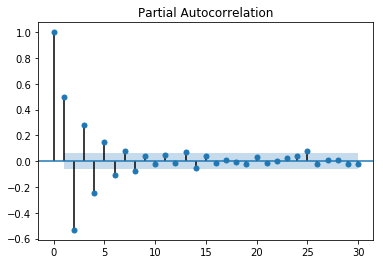

In [8]:
plot_pacf(model1, lags=30)
plt.show()

In [9]:
def test_arma(values, p=1,q=1):
    tmodel = ARMA(endog=values, order = (p,q))
    #We cannot use ARMA(values ) because we need to check order for every q to test.
    mf = tmodel.fit()
    print(mf.summary())
    print("k_ma = ", mf.k_ma)
    print("k_ar = ", mf.k_ar)
    print("coeff = ",mf.params)
    print("Conf Int \n",mf.conf_int())
    return mf

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(2, 2)   Log Likelihood               -1418.303
Method:                       css-mle   S.D. of innovations              0.998
Date:                Fri, 24 May 2019   AIC                           2848.606
Time:                        13:19:45   BIC                           2878.053
Sample:                             0   HQIC                          2859.798
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0613      0.052     -1.172      0.241      -0.164       0.041
ar.L1.y        0.5107      0.118      4.315      0.000       0.279       0.743
ar.L2.y       -0.3179      0.035     -9.210      0.0

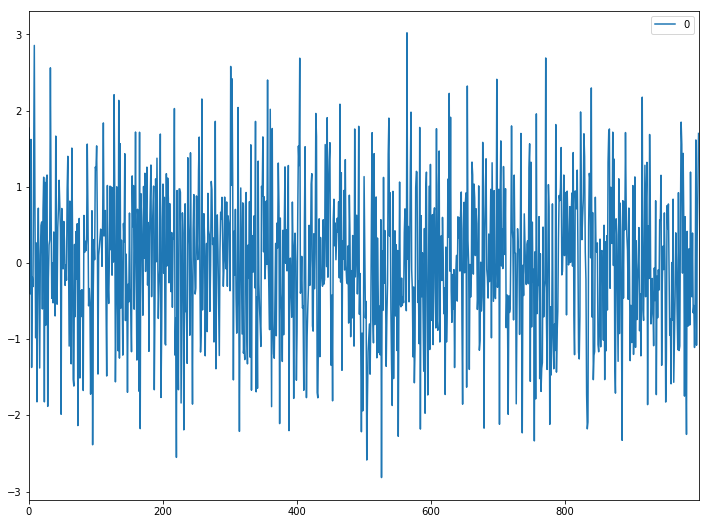

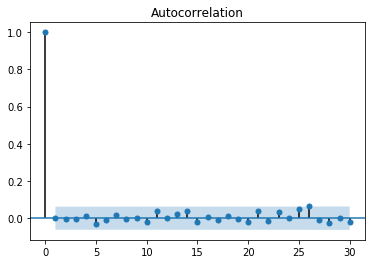

In [10]:
# test_ma_q(model, p=2,q=2)
mf = test_arma(model1, p=2,q=2)
pd.DataFrame(mf.resid).plot(figsize=(12,9))
plot_acf(mf.resid, lags=30)
plt.show()
#acf of residual series must be white noise

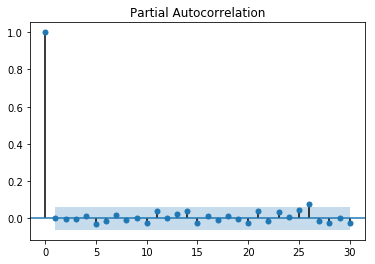

In [11]:
plot_pacf(mf.resid, lags=30)
plt.show()

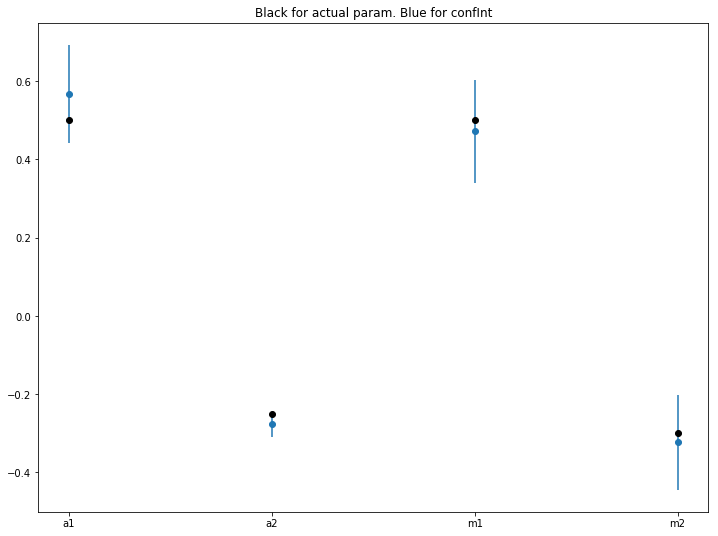

In [12]:
x = ['a1','a2','m1','m2']
y = [0.5665, -0.2774, 0.4712, -0.3226]
yerr = [0.126, 0.033, 0.131, 0.121]
plt.figure(figsize=(12,9))
plt.errorbar(x, y,yerr=yerr ,fmt='o')
plt.plot(x, [0.5, -0.25, 0.5, -0.3], 'ko')
#[np.array(yerr)*(-1.96), np.array(yerr)*1.96] ,
plt.title("Black for actual param. Blue for confInt")
plt.show()

In [13]:
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox
from IPython.display import display
def determine_arma_order(values):
    plt.plot(values)
    finalmodel = None
    finalorder = (0,0)
    finalaic = np.inf
    for p,q in product(list(range(4)), list(range(4))):
        print("testing for (%d, %d)"%(p,q))
        try:
            test = ARMA(endog=values, order=(p,q))
            tf = test.fit()
            aic = tf.aic
            if aic < finalaic:
                finalaic = aic
                finalorder = (p,q)
                finalmodel = test
        except:
            pass
            print("Cannot fit for (%d, %d)"%(p,q))
    print("final order, AIC: ", finalorder, finalaic)
    finalmodel = ARMA(endog=values, order=finalorder)
    resid = finalmodel.fit(ic='aic').resid
    #Ljung-box test to determine whether ARMA(p,q) is a good fit
    plot_acf(resid, lags=30)
    lbxresid = acorr_ljungbox(resid, lags=20)
    df = pd.DataFrame()
    df['test-Stat Q value'] = lbxresid[0]
    df['p-value'] = lbxresid[1]
    df['reject'] = df['p-value']<=0.05
    display(df)
    return finalorder

generating ARMA(1,0)
testing for (0, 0)
testing for (0, 1)
testing for (0, 2)
testing for (0, 3)
testing for (1, 0)
testing for (1, 1)
testing for (1, 2)
testing for (1, 3)
testing for (2, 0)
testing for (2, 1)
testing for (2, 2)
testing for (2, 3)
testing for (3, 0)
testing for (3, 1)
testing for (3, 2)
testing for (3, 3)
final order, AIC:  (1, 0) 2847.835876572487


test-Stat Q value   p-value  reject
0            0.000887  0.976243   False
1            0.777055  0.678055   False
2            2.394300  0.494696   False
3            2.458223  0.652132   False
4            2.771868  0.735107   False
5            2.801434  0.833324   False
6            3.552310  0.829654   False
7            5.602531  0.691656   False
8            5.803047  0.759457   False
9            7.304473  0.696422   False
10           7.307189  0.773689   False
11           7.490260  0.823590   False
12           8.145652  0.833983   False
13           8.310086  0.872554   False
14          16.075524  0.377050   False
15          16.935296  0.389796   False
16          17.707950  0.407485   False
17          17.722016  0.474102   False
18          18.004723  0.522123   False
19          18.177576  0.575712   False

(1, 0)

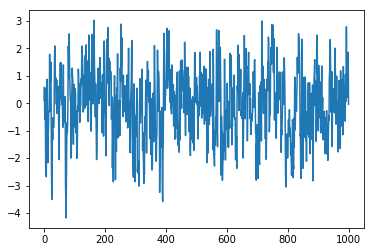

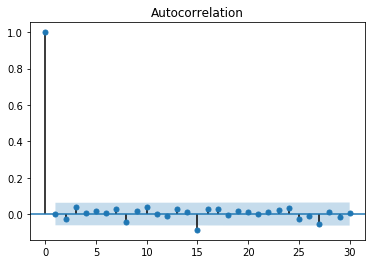

In [14]:
# values = generate_arma(n=1000, ar_coeff=[0.5, -0.25, -0.4], ma_coeff=[0.5, -0.3])
# values = np.diff(np.log(pd.read_csv('../data/INFY.csv')['Close']))
values = generate_arma(1000, ar_coeff=[0.6], ma_coeff=[])
determine_arma_order(values)

testing for (0, 0)
testing for (0, 1)
testing for (0, 2)
testing for (0, 3)
testing for (1, 0)
testing for (1, 1)
testing for (1, 2)
Cannot fit for (1, 2)
testing for (1, 3)
Cannot fit for (1, 3)
testing for (2, 0)
testing for (2, 1)
testing for (2, 2)
testing for (2, 3)
Cannot fit for (2, 3)
testing for (3, 0)
testing for (3, 1)
testing for (3, 2)
testing for (3, 3)


/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


final order, AIC:  (0, 1) -14326.287394262341


test-Stat Q value   p-value  reject
0            0.000026  0.995955   False
1            0.000245  0.999877   False
2            1.081817  0.781465   False
3            1.787189  0.774825   False
4            2.289290  0.807839   False
5            2.304435  0.889680   False
6            2.368685  0.936656   False
7            3.469959  0.901509   False
8            6.798104  0.658130   False
9            7.151267  0.711091   False
10          10.135936  0.518203   False
11          11.027047  0.526602   False
12          11.611827  0.559702   False
13          12.601628  0.558103   False
14          13.185077  0.588005   False
15          14.836502  0.536644   False
16          14.886207  0.603678   False
17          15.051717  0.658413   False
18          15.503937  0.690076   False
19          15.528322  0.745421   False

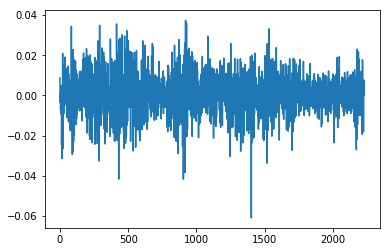

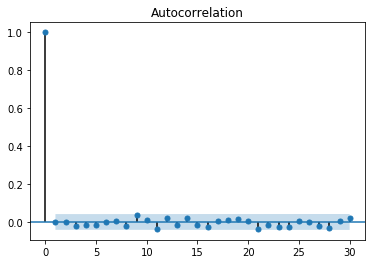

In [15]:
cl = get_pricing('../data/NIFTY 50.csv')
values = cl['diffLogClose'].values
order = determine_arma_order(cl['diffLogClose'].values)
model = ARMA(endog=cl['diffLogClose'].values, order=order)

[]

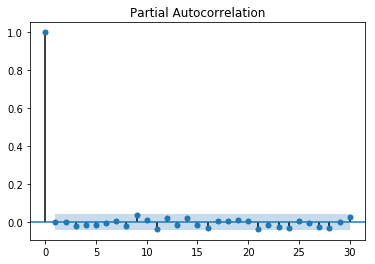

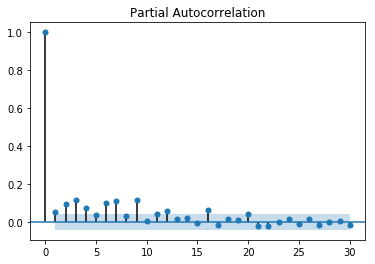

In [16]:
mf = model.fit()
resid = mf.resid
plot_pacf(resid, lags=30)
plt.plot()
plot_pacf(resid**2, lags=30)
plt.plot()

Iteration:      1,   Func. Count:     34,   Neg. LLF: -7261.613710652948
Iteration:      2,   Func. Count:     76,   Neg. LLF: -7261.962880969544
Iteration:      3,   Func. Count:    116,   Neg. LLF: -7261.962931963748
Iteration:      4,   Func. Count:    158,   Neg. LLF: -7261.963070748479
Iteration:      5,   Func. Count:    198,   Neg. LLF: -7261.963160010828
Iteration:      6,   Func. Count:    241,   Neg. LLF: -7261.963244322032
Iteration:      7,   Func. Count:    279,   Neg. LLF: -7261.971064759162
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -7261.971065337424
            Iterations: 11
            Function evaluations: 279
            Gradient evaluations: 7


/Users/sujogale/qstrader/qstraderp3/lib/python3.6/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


test-Stat Q value       p-value  reject
0            6.062837  1.380558e-02    True
1           30.196499  2.772768e-07    True
2           61.468443  2.854065e-13    True
3           78.924756  2.942784e-16    True
4           87.147475  2.668271e-17    True
5          123.222331  3.427640e-24    True
6          171.154381  1.433310e-33    True
7          184.382988  1.235582e-35    True
8          242.833987  3.244884e-47    True
9          249.756746  6.106200e-48    True
10         271.020984  1.091735e-51    True
11         295.141233  4.915621e-56    True
12         307.751945  5.733692e-58    True
13         322.979649  1.878173e-60    True
14         332.130418  1.136856e-61    True
15         365.968910  4.810305e-68    True
16         369.330397  4.672197e-68    True
17         385.131156  1.146220e-70    True
18         392.605436  1.510756e-71    True
19         413.073227  3.951383e-75    True

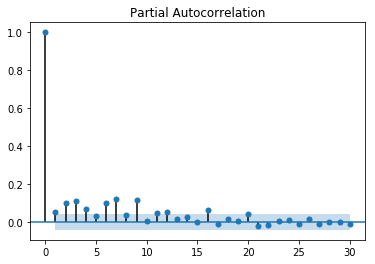

In [33]:
# GARCH STARTS
am = arch_model(y=values, mean='AR', vol='GARCH', p=15,q=15)
amf = am.fit()
plot_pacf(amf.resid**2, lags=30)
lbxresid = acorr_ljungbox(amf.resid, lags=20)
df = pd.DataFrame()
df['test-Stat Q value'] = lbxresid[0]
df['p-value'] = lbxresid[1]
df['reject'] = df['p-value']<=0.05
display(df)
# vl = amf.forecast(horizon=100).variance.values[-1:]
# print(vl)
# plt.plot(vl[0])
plt.show()